# PPO Training for Stock Trading

This notebook implements Proximal Policy Optimization (PPO) for training a reinforcement learning agent to trade stocks.

## Overview
- **Environment**: Stock trading environment using historical price data
- **Algorithm**: PPO (Proximal Policy Optimization)
- **Model**: Actor-Critic network (MLP or CNN)
- **Features**: Volume, extra features (volatility, ATR-like), chronological train/val split


## 1. Imports and Setup


In [1]:
import os
import time
import random

import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter

# Import our stock trading environment package
from stock_trading_env import (
    StocksEnv,
    load_many_from_dir,
    split_many_by_ratio,
    Actions,
)

# ---------- Reproducibility ----------
def set_seed(seed: int, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Pick a default seed (match your CLI default if you had one)
SEED = 0
set_seed(SEED, deterministic=True)

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Output directories ----------
os.makedirs("runs", exist_ok=True)
os.makedirs("saves", exist_ok=True)
os.makedirs("logs", exist_ok=True)

print("✓ Imports successful")
print(f"Seed: {SEED} (deterministic=True)")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✓ Imports successful
Seed: 0 (deterministic=True)
PyTorch version: 2.9.0+cpu
CUDA available: False
Device: cpu


## 2. PPO Model Definitions

Define the Actor-Critic networks for PPO.


In [2]:
# Cell 2: PPO Actor-Critic models (DISCRETE actions) — matches earlier repo logic

import torch
import torch.nn as nn


class ActorCriticMLP(nn.Module):
    """
    PPO Actor-Critic for DISCRETE actions (vector observation).

    Input:  x (B, obs_dim)
    Output: logits (B, n_actions), value (B,)
      - logits are unnormalized scores for torch.distributions.Categorical(logits=logits)
      - value is V(s) for GAE/advantage estimation
    """

    def __init__(self, obs_dim: int, n_actions: int, hidden: int = 256):
        super().__init__()

        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        self.policy_head = nn.Linear(hidden, n_actions)
        self.value_head = nn.Linear(hidden, 1)

        self._init_weights()

    def _init_weights(self):
        # Orthogonal init is common for PPO
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.constant_(m.bias, 0.0)

        # Smaller gain for the final policy head helps early training stability
        nn.init.orthogonal_(self.policy_head.weight, gain=0.01)
        nn.init.constant_(self.policy_head.bias, 0.0)

    def forward(self, x: torch.Tensor):
        z = self.shared(x)
        logits = self.policy_head(z)
        value = self.value_head(z).squeeze(-1)
        return logits, value


class ActorCriticConv1D(nn.Module):
    """
    PPO Actor-Critic for State1D observations (CNN over time bars).

    Expected env State1D shape (C, T) where:
      - C = (3 + (1 if volumes else 0)) + 2  -> typically 6 if volumes=True
      - T = bars_count (e.g., 10)

    Input:  x (B, C, T)
    Output: logits (B, n_actions), value (B,)
    """

    def __init__(self, n_actions: int, bars_count: int, volumes: bool = True, hidden: int = 256):
        super().__init__()

        # Match env.State1D channel logic:
        # base channels: 3 + (1 if volumes else 0)
        # +2 for (have_position, unrealized_return)
        in_channels = (3 + (1 if volumes else 0)) + 2

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),  # -> (B, 64 * bars_count)
        )

        conv_out = 64 * bars_count

        self.shared = nn.Sequential(
            nn.Linear(conv_out, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        self.policy_head = nn.Linear(hidden, n_actions)
        self.value_head = nn.Linear(hidden, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.orthogonal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

        nn.init.orthogonal_(self.policy_head.weight, gain=0.01)
        nn.init.constant_(self.policy_head.bias, 0.0)

    def forward(self, x: torch.Tensor):
        feat = self.conv(x)
        z = self.shared(feat)
        logits = self.policy_head(z)
        value = self.value_head(z).squeeze(-1)
        return logits, value


print("✓ PPO models defined (MLP + Conv1D)")
print("  - Use ActorCriticMLP for vector obs")
print("  - Use ActorCriticConv1D only if env returns State1D (C,T), e.g. (6, bars)")

✓ PPO models defined (MLP + Conv1D)
  - Use ActorCriticMLP for vector obs
  - Use ActorCriticConv1D only if env returns State1D (C,T), e.g. (6, bars)


## 3. PPO Buffer and Utilities

Define the rollout buffer for collecting experience and computing GAE advantages.


In [3]:
# Cell 3 (updated): RolloutBuffer + PPOBatch
# Fixes/robustness:
# - Safer dtype/device handling
# - Enforces add() obs shape
# - Handles truncated/terminated properly via done float
# - Supports 1D (vector) and 2D (C,T) observations cleanly
# - Compute GAE in float32, normalize advantages safely
# - Optional pin_memory for faster CPU->GPU transfer

from dataclasses import dataclass
from typing import Iterator, Optional, Tuple, Union

import numpy as np
import torch


@dataclass
class PPOBatch:
    """One minibatch used during PPO updates."""
    obs: torch.Tensor
    actions: torch.Tensor
    old_logprobs: torch.Tensor
    advantages: torch.Tensor
    returns: torch.Tensor
    old_values: torch.Tensor


class RolloutBuffer:
    """
    Fixed-length rollout buffer for PPO.

    Stores:
      obs[t], action[t], reward[t], done[t], value[t], logprob[t]

    After calling compute_gae():
      advantages[t], returns[t] are filled.

    Notes:
      - done should be True when episode ended for ANY reason:
        done = terminated OR truncated (Gymnasium).
      - obs can be vector (obs_dim,) or State1D (C,T).
    """

    def __init__(
        self,
        obs_shape: Union[int, Tuple[int, ...]],
        size: int,
        device: Union[str, torch.device] = "cpu",
        obs_dtype: np.dtype = np.float32,
        pin_memory: bool = False,
    ):
        if isinstance(obs_shape, int):
            obs_shape = (obs_shape,)
        self.obs_shape = tuple(obs_shape)
        self.size = int(size)
        self.device = torch.device(device) if not isinstance(device, torch.device) else device
        self.pin_memory = bool(pin_memory) and (self.device.type == "cuda")

        # Storage (numpy)
        self.obs = np.zeros((self.size, *self.obs_shape), dtype=obs_dtype)
        self.actions = np.zeros((self.size,), dtype=np.int64)
        self.rewards = np.zeros((self.size,), dtype=np.float32)
        self.dones = np.zeros((self.size,), dtype=np.float32)   # 1.0 if done else 0.0
        self.values = np.zeros((self.size,), dtype=np.float32)
        self.logprobs = np.zeros((self.size,), dtype=np.float32)

        # Computed after rollout
        self.advantages = np.zeros((self.size,), dtype=np.float32)
        self.returns = np.zeros((self.size,), dtype=np.float32)

        self.ptr = 0
        self.full = False

    def reset(self):
        self.ptr = 0
        self.full = False

    def add(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        done: bool,
        value: float,
        logprob: float,
    ):
        """Add one transition."""
        if self.ptr >= self.size:
            raise RuntimeError("RolloutBuffer is full. Call reset() before adding more.")

        obs_arr = np.asarray(obs, dtype=self.obs.dtype)

        # Enforce shape to catch silent bugs early (common in notebooks)
        if obs_arr.shape != self.obs_shape:
            raise ValueError(
                f"Obs shape mismatch: got {obs_arr.shape}, expected {self.obs_shape}. "
                "Check env output (vector vs State1D) and model input."
            )

        self.obs[self.ptr] = obs_arr
        self.actions[self.ptr] = int(action)
        self.rewards[self.ptr] = float(reward)
        self.dones[self.ptr] = 1.0 if bool(done) else 0.0
        self.values[self.ptr] = float(value)
        self.logprobs[self.ptr] = float(logprob)

        self.ptr += 1
        self.full = (self.ptr == self.size)

    @torch.no_grad()
    def compute_gae(
        self,
        last_value: float,
        gamma: float = 0.99,
        lam: float = 0.95,
        normalize_adv: bool = True,
        eps: float = 1e-8,
    ):
        """
        Compute GAE(lambda) advantages and returns.

        last_value should be V(s_T) for the *last obs after the rollout*,
        used to bootstrap if the last transition was not terminal.
        """
        if not self.full:
            raise RuntimeError("RolloutBuffer not full. Collect 'size' steps before compute_gae().")

        last_value = float(last_value)

        adv = 0.0
        for t in reversed(range(self.size)):
            done = self.dones[t]
            mask = 1.0 - done  # 0 if terminal else 1

            next_value = last_value if (t == self.size - 1) else float(self.values[t + 1])
            delta = float(self.rewards[t]) + gamma * next_value * mask - float(self.values[t])

            adv = delta + gamma * lam * mask * adv
            self.advantages[t] = adv

        # returns target for critic
        self.returns = self.advantages + self.values

        if normalize_adv:
            m = float(self.advantages.mean())
            s = float(self.advantages.std())
            self.advantages = (self.advantages - m) / (s + eps)

    def get_batches(self, batch_size: int, shuffle: bool = True) -> Iterator[PPOBatch]:
        """Yield mini-batches as torch tensors."""
        if not self.full:
            raise RuntimeError("RolloutBuffer not full. Collect rollout before batching.")

        if batch_size <= 0:
            raise ValueError("batch_size must be > 0")

        idxs = np.arange(self.size)
        if shuffle:
            np.random.shuffle(idxs)

        for start in range(0, self.size, batch_size):
            b_idx = idxs[start : start + batch_size]

            # CPU tensors first (optionally pinned), then move to device
            obs_cpu = torch.from_numpy(self.obs[b_idx]).float()
            if self.pin_memory:
                obs_cpu = obs_cpu.pin_memory()
            obs_t = obs_cpu.to(self.device, non_blocking=self.pin_memory)

            actions_t = torch.from_numpy(self.actions[b_idx]).long().to(self.device)
            old_logp_t = torch.from_numpy(self.logprobs[b_idx]).float().to(self.device)
            adv_t = torch.from_numpy(self.advantages[b_idx]).float().to(self.device)
            ret_t = torch.from_numpy(self.returns[b_idx]).float().to(self.device)
            old_v_t = torch.from_numpy(self.values[b_idx]).float().to(self.device)

            yield PPOBatch(
                obs=obs_t,
                actions=actions_t,
                old_logprobs=old_logp_t,
                advantages=adv_t,
                returns=ret_t,
                old_values=old_v_t,
            )


print("✓ PPO buffer defined (updated/robust)")

✓ PPO buffer defined (updated/robust)


# Cell 4

In [4]:
from typing import Dict, Any
import numpy as np
import torch
from torch.distributions import Categorical

@torch.no_grad()
def policy_act(model, obs, device: torch.device, greedy: bool = False):
    """
    Sample (or greedy-select) action from current policy.
    Returns: action(int), logprob(float), value(float)
    Works for both:
      - vector obs: (obs_dim,)
      - State1D obs: (C, T)
    """
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, value = model(obs_t)
    dist = Categorical(logits=logits)

    if greedy:
        action_t = torch.argmax(logits, dim=1)
    else:
        action_t = dist.sample()

    logprob_t = dist.log_prob(action_t)
    return int(action_t.item()), float(logprob_t.item()), float(value.item())


def explained_variance(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """1 - Var[y_true - y_pred] / Var[y_true]. Diagnostic for critic fit."""
    var_y = float(np.var(y_true))
    if var_y < 1e-12:
        return 0.0
    return float(1.0 - np.var(y_true - y_pred) / (var_y + 1e-12))


@torch.no_grad()
def validation_run_ppo(env, model, episodes: int = 50, device="cpu", greedy: bool = False) -> Dict[str, float]:
    """
    Evaluate a PPO policy on the given environment.
    Returns mean metrics across episodes.

    IMPORTANT: This assumes the env executes actions at OPEN(t+1), consistent with your repo env.
    """
    device = torch.device(device) if not isinstance(device, torch.device) else device

    # Ensure deterministic eval behavior (dropout/bn etc.)
    was_training = model.training
    model.eval()

    base_env = env.unwrapped if hasattr(env, "unwrapped") else env
    st = getattr(base_env, "_state", None)
    if st is None:
        # restore mode before raising
        if was_training:
            model.train()
        raise AttributeError("validation_run_ppo expected env.unwrapped to have attribute '_state'.")

    stats = {
        "episode_reward": [],
        "episode_steps": [],
        "num_trades": [],
        "win_rate": [],
        "avg_trade_return": [],
        "avg_hold_steps": [],
        "sum_trade_return": [],
    }

    for _ in range(episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        # Manual trade tracking (OPEN(t+1) execution)
        in_pos = False
        entry_price = None
        hold_steps = 0
        trade_returns = []
        trade_hold_steps = []

        while not done:
            action, _lp, _v = policy_act(model, obs, device=device, greedy=greedy)

            # Safer enum conversion
            try:
                act_enum = Actions(action)
            except Exception:
                # If action is invalid, treat as "Skip" (safe fallback)
                act_enum = Actions.Skip

            # Access state after reset/step (base_env._state can change reference)
            st = base_env._state
            next_idx = st._offset + 1

            exec_open = None
            if 0 <= next_idx < st._prices.open.shape[0]:
                exec_open = float(st._prices.open[next_idx])

            prev_have_pos_env = bool(st.have_position)

            # Bookkeeping BEFORE env.step(), using OPEN(t+1)
            if exec_open is not None:
                if act_enum == Actions.Buy and not in_pos:
                    in_pos = True
                    entry_price = exec_open
                    hold_steps = 0
                elif act_enum == Actions.Close and in_pos:
                    if entry_price is not None and entry_price > 0:
                        tr = 100.0 * (exec_open - entry_price) / entry_price
                    else:
                        tr = 0.0
                    trade_returns.append(tr)
                    trade_hold_steps.append(hold_steps)
                    in_pos = False
                    entry_price = None
                    hold_steps = 0

            # Step environment
            obs, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            total_reward += float(reward)
            steps += 1

            # Detect forced close by env (stop-loss / done close, etc.)
            now_have_pos_env = bool(base_env._state.have_position)
            if in_pos and prev_have_pos_env and (not now_have_pos_env) and act_enum != Actions.Close:
                # Use exec_open if available (OPEN(t+1)), else fallback to current close
                exit_price = exec_open if exec_open is not None else float(base_env._state._cur_close())
                if entry_price is not None and entry_price > 0:
                    tr = 100.0 * (exit_price - entry_price) / entry_price
                else:
                    tr = 0.0
                trade_returns.append(tr)
                trade_hold_steps.append(hold_steps)
                in_pos = False
                entry_price = None
                hold_steps = 0

            if in_pos:
                hold_steps += 1

        # If episode ends while holding, close at last close for reporting
        if in_pos and entry_price is not None and entry_price > 0:
            last_close = float(base_env._state._cur_close())
            tr = 100.0 * (last_close - entry_price) / entry_price
            trade_returns.append(tr)
            trade_hold_steps.append(hold_steps)

        # Episode metrics
        stats["episode_reward"].append(total_reward)
        stats["episode_steps"].append(steps)

        n_trades = len(trade_returns)
        stats["num_trades"].append(float(n_trades))

        if n_trades > 0:
            wins = sum(1 for x in trade_returns if x > 0.0)
            stats["win_rate"].append(float(wins / n_trades))
            stats["avg_trade_return"].append(float(np.mean(trade_returns)))
            stats["avg_hold_steps"].append(float(np.mean(trade_hold_steps)))
            stats["sum_trade_return"].append(float(np.sum(trade_returns)))
        else:
            stats["win_rate"].append(0.0)
            stats["avg_trade_return"].append(0.0)
            stats["avg_hold_steps"].append(0.0)
            stats["sum_trade_return"].append(0.0)

    # Restore model mode
    if was_training:
        model.train()

    return {k: float(np.mean(v)) for k, v in stats.items()}


print("✓ Helper functions defined (updated/robust)")

✓ Helper functions defined (updated/robust)


# Cell 5

In [5]:
# ===== Training Configuration (CLI-aligned + holding cost + reason-to-close shaping) =====
config = {
    # Data
    "data_dir": "yf_data",
    "run_name": f"ppo_aapl_{time.strftime('%Y%m%d_%H%M%S')}",
    "seed": 0,

    # Device
    "use_cuda": True,

    # PPO Hyperparameters (UNCHANGED)
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_eps": 0.2,
    "lr": 3e-4,
    "rollout_steps": 1024,
    "minibatch": 256,
    "epochs": 5,
    "value_coef": 0.5,
    "entropy_coef": 0.025,
    "max_grad_norm": 0.5,
    "target_kl": 0.03,

    # Environment
    "bars": 10,
    "volumes": True,
    "extra_features": True,
    "reward_mode": "close_pnl",
    "state_1d": False,
    "time_limit": 1000,

    # Holding-cost controls
    "hold_penalty_per_step": 2e-4,
    "max_hold_steps": 20,

    # >>> NEW: Reason-to-close shaping (START CONSERVATIVE) <<<
    # Penalize holding unrealized losses (scaled by magnitude of negative unrealized return)
    "unrealized_loss_penalty_per_step": 0.10,   # try 0.05–0.20
    # Bonus when closing profitable trades (scaled by realized return)
    "close_profit_bonus": 0.20,                 # try 0.05–0.30
    # Penalize volatility while holding (start at 0.0; add later if needed)
    "unrealized_vol_penalty_per_step": 0.00,    # keep 0.0 initially
    "vol_lookback": 20,

    # Data Split
    "split": True,
    "train_ratio": 0.8,
    "min_train": 300,
    "min_val": 300,

    # Training Control
    "max_rollouts": 500,
    "total_steps": 10_000_000,

    # Validation & Checkpointing
    "val_every_rollouts": 10,
    "save_every_rollouts": 5,
    "early_stop": True,
    "patience": 20,
    "min_rollouts": 50,
    "min_delta": 0.01,
}

# Set device (matches --cuda behavior)
device = torch.device("cuda" if (config["use_cuda"] and torch.cuda.is_available()) else "cpu")
print(f"Using device: {device}")

# Set seed
set_seed(config["seed"])

print("✓ Configuration set (hold cost + reason-to-close shaping)")

Using device: cpu
✓ Configuration set (hold cost + reason-to-close shaping)


## 6. Load and Prepare Data

Load stock price data and split into train/validation sets.


In [6]:
# Load all price data
prices_all = load_many_from_dir(config["data_dir"])
print(f"Loaded {len(prices_all)} instruments: {list(prices_all.keys())}")

# Optional: if you want to exactly match an AAPL-only run
# TARGET = "AAPL"
# if TARGET in prices_all:
#     prices_all = {TARGET: prices_all[TARGET]}
#     print(f"Filtered to single instrument: {TARGET}")

# Split into train/validation (chronological, no leakage)
if config["split"]:
    prices_train, prices_val = split_many_by_ratio(
        prices_all,
        train_ratio=config["train_ratio"],
        min_train=config["min_train"],
        min_val=config["min_val"],
    )
    print(f"Train instruments: {len(prices_train)}")
    print(f"Validation instruments: {len(prices_val)}")
else:
    prices_train = prices_all
    prices_val = prices_all
    print("No split: using same data for train and validation (in-sample)")

# Sanity checks (strongly recommended)
for k in prices_train.keys():
    tr_len = len(prices_train[k].close)
    va_len = len(prices_val[k].close)
    if config["split"]:
        assert tr_len >= config["min_train"], f"{k}: train too short ({tr_len})"
        assert va_len >= config["min_val"], f"{k}: val too short ({va_len})"
    print(f"  {k}: train_len={tr_len}, val_len={va_len}")

print("✓ Data loaded and split")

Loaded 1 instruments: ['AAPL_1d_2020-01-01_to_2025-12-23']
Train instruments: 1
Validation instruments: 1
  AAPL_1d_2020-01-01_to_2025-12-23: train_len=1201, val_len=301
✓ Data loaded and split


## 7. Create Environments

Set up training and validation environments.


In [7]:
# Create training environment (match CLI behavior + shaping)
env_train_base = StocksEnv(
    prices_train,
    bars_count=config["bars"],
    volumes=config["volumes"],
    extra_features=config["extra_features"],
    reward_mode=config["reward_mode"],
    state_1d=config["state_1d"],
    hold_penalty_per_step=float(config["hold_penalty_per_step"]),
    max_hold_steps=config.get("max_hold_steps", None),

    # >>> NEW: reason-to-close shaping <<<
    unrealized_loss_penalty_per_step=float(config["unrealized_loss_penalty_per_step"]),
    close_profit_bonus=float(config["close_profit_bonus"]),
    unrealized_vol_penalty_per_step=float(config["unrealized_vol_penalty_per_step"]),
    vol_lookback=int(config["vol_lookback"]),
)
env_train = gym.wrappers.TimeLimit(env_train_base, max_episode_steps=config["time_limit"])

# Create validation environment (same settings + same TimeLimit)
env_val_base = StocksEnv(
    prices_val,
    bars_count=config["bars"],
    volumes=config["volumes"],
    extra_features=config["extra_features"],
    reward_mode=config["reward_mode"],
    state_1d=config["state_1d"],
    hold_penalty_per_step=float(config["hold_penalty_per_step"]),
    max_hold_steps=config.get("max_hold_steps", None),

    # >>> NEW: reason-to-close shaping <<<
    unrealized_loss_penalty_per_step=float(config["unrealized_loss_penalty_per_step"]),
    close_profit_bonus=float(config["close_profit_bonus"]),
    unrealized_vol_penalty_per_step=float(config["unrealized_vol_penalty_per_step"]),
    vol_lookback=int(config["vol_lookback"]),
)
env_val = gym.wrappers.TimeLimit(env_val_base, max_episode_steps=config["time_limit"])

obs_shape = env_train.observation_space.shape
n_actions = env_train.action_space.n

print(f"Observation space: {obs_shape}")
print(f"Action space: {n_actions} actions")
print("✓ Environments created (with hold cost + reason-to-close shaping)")

Observation space: (45,)
Action space: 3 actions
✓ Environments created (with hold cost + reason-to-close shaping)


## 8. Initialize Model and Optimizer

Create the PPO model and optimizer.


In [8]:
# Cell 8: Build model + optimizer + TensorBoard writer (compatible with updated Cell 2)

# Infer observation shape from env
# - Vector state: obs_shape = (obs_dim,)
# - State1D:      obs_shape = (C, T)
if config["state_1d"]:
    C, T = obs_shape  # (channels, time bars)

    # Our updated ActorCriticConv1D computes in_channels internally from `volumes`
    # (C should equal (3 + (1 if volumes else 0)) + 2, usually 6 if volumes=True)
    expected_C = (3 + (1 if config["volumes"] else 0)) + 2
    if C != expected_C:
        raise ValueError(
            f"State1D channel mismatch: env returned C={C}, expected C={expected_C}. "
            "Check env volumes/state_1d settings."
        )

    model = ActorCriticConv1D(
        n_actions=n_actions,
        bars_count=T,
        volumes=config["volumes"],
        hidden=256,
    ).to(device)

    print(f"Created Conv1D model: C={C}, T={T}")
else:
    obs_dim = obs_shape[0]
    model = ActorCriticMLP(obs_dim=obs_dim, n_actions=n_actions, hidden=256).to(device)
    print(f"Created MLP model: obs_dim={obs_dim}")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

# TensorBoard writer (clean run directory like scripts usually do)
log_dir = os.path.join("runs", config["run_name"])
writer = SummaryWriter(log_dir=log_dir)
print(f"[TB] logging to: {log_dir}")
print("Model params:", sum(p.numel() for p in model.parameters()))

print("✓ Model and optimizer initialized")


Created MLP model: obs_dim=45
[TB] logging to: runs\ppo_aapl_20251228_181038
Model params: 78596
✓ Model and optimizer initialized


## 9. Training Loop

Main PPO training loop: collect rollouts, compute advantages, update policy.


In [9]:
# ===== Training bookkeeping =====
obs, info = env_train.reset(seed=config["seed"])
episode_reward = 0.0
episode_steps = 0
episode_count = 0

global_step = 0
rollout_idx = 0
t0 = time.time()

best_val_metric = -1e9  # now tracking sum_trade_return by default
no_improve = 0

print(f"[PPO] device={device} obs_shape={obs_shape} actions={n_actions}")
print(f"[PPO] reward_mode={config['reward_mode']} volumes={config['volumes']} extra_features={config['extra_features']}")
print(f"[PPO] split={config['split']} max_rollouts={config['max_rollouts']} early_stop={config['early_stop']}")
print(f"[PPO] logs: runs/  checkpoints: saves/")
print("=" * 60)

# Main training loop
while (global_step < config["total_steps"]) and (rollout_idx < config["max_rollouts"]):
    rollout_idx += 1
    buf = RolloutBuffer(obs_shape=obs_shape, size=config["rollout_steps"], device=device)

    # >>> NEW: action distribution counters (per-rollout) <<<
    act_counts = np.zeros(n_actions, dtype=np.int64)

    # ===== Collect Rollout =====
    for _ in range(config["rollout_steps"]):
        global_step += 1

        action, logprob, value = policy_act(model, obs, device=device, greedy=False)
        if 0 <= action < n_actions:
            act_counts[action] += 1

        next_obs, reward, terminated, truncated, info = env_train.step(action)

        episode_done = bool(terminated or truncated)

        # IMPORTANT FIX: mask GAE on ANY episode end (terminated OR truncated)
        buf_done = episode_done

        buf.add(
            obs=obs,
            action=action,
            reward=float(reward),
            done=buf_done,
            value=value,
            logprob=logprob,
        )

        episode_reward += float(reward)
        episode_steps += 1
        obs = next_obs

        if episode_done:
            episode_count += 1
            writer.add_scalar("train/episode_reward", episode_reward, global_step)
            writer.add_scalar("train/episode_steps", episode_steps, global_step)

            obs, info = env_train.reset()
            episode_reward = 0.0
            episode_steps = 0

        if global_step >= config["total_steps"]:
            break

    # If we didn't fill the buffer (e.g., hit total_steps), stop cleanly
    if not buf.full:
        print(f"[PPO] stopping: reached total_steps mid-rollout (filled {buf.ptr}/{buf.size}).")
        break

    # >>> NEW: log action distribution <<<
    act_fracs = act_counts.astype(np.float32) / float(act_counts.sum() + 1e-8)
    writer.add_scalar("train/action_frac_skip", float(act_fracs[Actions.Skip.value]), global_step)
    writer.add_scalar("train/action_frac_buy", float(act_fracs[Actions.Buy.value]), global_step)
    writer.add_scalar("train/action_frac_close", float(act_fracs[Actions.Close.value]), global_step)

    # Rollout reward heartbeat
    roll_sum = float(buf.rewards.sum())
    roll_mean = float(buf.rewards.mean())
    writer.add_scalar("train/rollout_reward_sum", roll_sum, global_step)
    writer.add_scalar("train/rollout_reward_mean", roll_mean, global_step)

    # Bootstrap last value for GAE (used even if last is terminal; mask in GAE handles it)
    with torch.no_grad():
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        _, last_v = model(obs_t)
        last_value = float(last_v.item())

    buf.compute_gae(
        last_value=last_value,
        gamma=config["gamma"],
        lam=config["gae_lambda"],
        normalize_adv=True,
    )

    # ===== PPO Update =====
    policy_losses = []
    value_losses = []
    entropies = []
    approx_kls = []
    clipfracs = []

    for _epoch in range(config["epochs"]):
        for batch in buf.get_batches(batch_size=config["minibatch"], shuffle=True):
            logits, values = model(batch.obs)
            dist = Categorical(logits=logits)

            new_logp = dist.log_prob(batch.actions)
            entropy = dist.entropy().mean()

            # PPO ratio
            ratio = torch.exp(new_logp - batch.old_logprobs)

            # Policy loss (clipped surrogate)
            unclipped = ratio * batch.advantages
            clipped = torch.clamp(ratio, 1.0 - config["clip_eps"], 1.0 + config["clip_eps"]) * batch.advantages
            loss_pi = -torch.min(unclipped, clipped).mean()

            # Value loss
            loss_v = (batch.returns - values).pow(2).mean()

            # Total loss
            loss = loss_pi + config["value_coef"] * loss_v - config["entropy_coef"] * entropy

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
            optimizer.step()

            with torch.no_grad():
                # PPO-style KL approximation (no abs)
                approx_kl = float((batch.old_logprobs - new_logp).mean().item())
                clipfrac = float((torch.abs(ratio - 1.0) > config["clip_eps"]).float().mean().item())

            policy_losses.append(float(loss_pi.item()))
            value_losses.append(float(loss_v.item()))
            entropies.append(float(entropy.item()))
            approx_kls.append(approx_kl)
            clipfracs.append(clipfrac)

        # Early stop PPO epoch loop if KL too big
        if config["target_kl"] > 0 and approx_kls and (np.mean(approx_kls) > config["target_kl"]):
            break

    # ===== Logging =====
    fps = global_step / max(1e-9, (time.time() - t0))
    writer.add_scalar("ppo/policy_loss", float(np.mean(policy_losses) if policy_losses else 0.0), global_step)
    writer.add_scalar("ppo/value_loss", float(np.mean(value_losses) if value_losses else 0.0), global_step)
    writer.add_scalar("ppo/entropy", float(np.mean(entropies) if entropies else 0.0), global_step)
    writer.add_scalar("ppo/approx_kl", float(np.mean(approx_kls) if approx_kls else 0.0), global_step)
    writer.add_scalar("ppo/clipfrac", float(np.mean(clipfracs) if clipfracs else 0.0), global_step)
    writer.add_scalar("train/fps", float(fps), global_step)
    writer.add_scalar("train/episodes", float(episode_count), global_step)

    # Value function explained variance
    ev = explained_variance(np.asarray(buf.values), np.asarray(buf.returns))
    writer.add_scalar("ppo/explained_variance", ev, global_step)

    # Console heartbeat (includes action fractions)
    print(
        f"[rollout {rollout_idx}] step={global_step} "
        f"roll_sum={roll_sum:.3f} roll_mean={roll_mean:.5f} "
        f"pi_loss={np.mean(policy_losses) if policy_losses else 0.0:.4f} "
        f"v_loss={np.mean(value_losses) if value_losses else 0.0:.4f} "
        f"ent={np.mean(entropies) if entropies else 0.0:.3f} "
        f"kl={np.mean(approx_kls) if approx_kls else 0.0:.4f} "
        f"clip={np.mean(clipfracs) if clipfracs else 0.0:.3f} "
        f"eps_done={episode_count} fps={fps:.1f} "
        f"a=[S:{act_fracs[Actions.Skip.value]:.2f},B:{act_fracs[Actions.Buy.value]:.2f},C:{act_fracs[Actions.Close.value]:.2f}]"
    )

    # ===== Validation + Best Model Saving + Early Stop =====
    if config["val_every_rollouts"] > 0 and (rollout_idx % config["val_every_rollouts"] == 0):
        val = validation_run_ppo(env_val, model, episodes=20, device=device, greedy=True)

        for k, v in val.items():
            writer.add_scalar("val/" + k, v, global_step)

        # Also log which metric we're optimizing for checkpointing
        cur_sum_tr = float(val.get("sum_trade_return", -1e9))
        cur_ep_rew = float(val.get("episode_reward", -1e9))

        print(f"  [val] {val}")

        # Choose best checkpoint by sum_trade_return (more trading-relevant than shaped reward)
        cur_metric = cur_sum_tr

        if cur_metric > best_val_metric + config["min_delta"]:
            best_val_metric = cur_metric
            no_improve = 0
            best_path = os.path.join("saves", f"ppo_{config['run_name']}_best.pt")
            torch.save(model.state_dict(), best_path)
            print(
                f"  [best] new best val sum_trade_return={best_val_metric:.4f} "
                f"(episode_reward={cur_ep_rew:.4f}) -> {best_path}"
            )
        else:
            no_improve += 1

        if config["early_stop"] and (rollout_idx >= config["min_rollouts"]) and (no_improve >= config["patience"]):
            print(f"[PPO] early stopping: no val improvement for {no_improve} validations.")
            break

    # ===== Save Periodic Checkpoint =====
    if config["save_every_rollouts"] > 0 and (rollout_idx % config["save_every_rollouts"] == 0):
        ckpt_path = os.path.join("saves", f"ppo_{config['run_name']}_rollout{rollout_idx}.pt")
        torch.save(model.state_dict(), ckpt_path)
        print(f"  [save] {ckpt_path}")

    # Hard stop condition
    if config["max_rollouts"] and rollout_idx >= config["max_rollouts"]:
        print("[PPO] reached max_rollouts, stopping.")
        break

if global_step >= config["total_steps"]:
    print(f"[done] reached total_steps={config['total_steps']} at rollout={rollout_idx}")
elif rollout_idx >= config["max_rollouts"]:
    print(f"[done] reached max_rollouts={config['max_rollouts']} at step={global_step}")

writer.close()
print("\n✓ Training completed!")

[PPO] device=cpu obs_shape=(45,) actions=3
[PPO] reward_mode=close_pnl volumes=True extra_features=True
[PPO] split=True max_rollouts=500 early_stop=True
[PPO] logs: runs/  checkpoints: saves/
[rollout 1] step=1024 roll_sum=-20.033 roll_mean=-0.01956 pi_loss=-0.0002 v_loss=17.0130 ent=1.099 kl=0.0002 clip=0.000 eps_done=2 fps=730.4 a=[S:0.35,B:0.32,C:0.34]
[rollout 2] step=2048 roll_sum=39.426 roll_mean=0.03850 pi_loss=-0.0004 v_loss=18.6224 ent=1.099 kl=0.0001 clip=0.000 eps_done=3 fps=781.1 a=[S:0.34,B:0.33,C:0.32]
[rollout 3] step=3072 roll_sum=-0.453 roll_mean=-0.00044 pi_loss=-0.0008 v_loss=13.4298 ent=1.098 kl=0.0011 clip=0.000 eps_done=4 fps=784.4 a=[S:0.36,B:0.30,C:0.34]
[rollout 4] step=4096 roll_sum=71.482 roll_mean=0.06981 pi_loss=0.0002 v_loss=22.1402 ent=1.097 kl=-0.0001 clip=0.000 eps_done=5 fps=764.0 a=[S:0.31,B:0.35,C:0.34]
[rollout 5] step=5120 roll_sum=54.330 roll_mean=0.05306 pi_loss=-0.0026 v_loss=31.3790 ent=1.093 kl=0.0011 clip=0.000 eps_done=6 fps=756.5 a=[S:0.31

# Cell 10: Load best model + final validation

Loaded best model from: saves\ppo_ppo_aapl_20251228_181038_best.pt

######################################################################
Backtests using GREEDY policy
######################################################################

Backtest Metrics ($10k, greedy, run 1/3):
  instrument: AAPL_1d_2020-01-01_to_2025-12-23
  steps: 129
  initial_cash: 10000.0000
  final_equity: 8909.4065
  total_return_pct: -10.9059
  max_drawdown_pct: 12.8814
  num_round_trips: 64
  win_rate: 0.5781
  avg_hold_steps: 0.9844
  avg_trade_pnl_usd: 1.9601
  avg_trade_pnl_pct: 0.0240
  chosen_frac_skip: 0.0000
  chosen_frac_buy: 0.5039
  chosen_frac_close: 0.4961
  exec_buys: 64
  exec_sells: 63
  exec_liquidations: 1
  sizing: all_in_int_shares
  commission_perc: 0.0010
  force_liquidate: True
  policy_eval: greedy


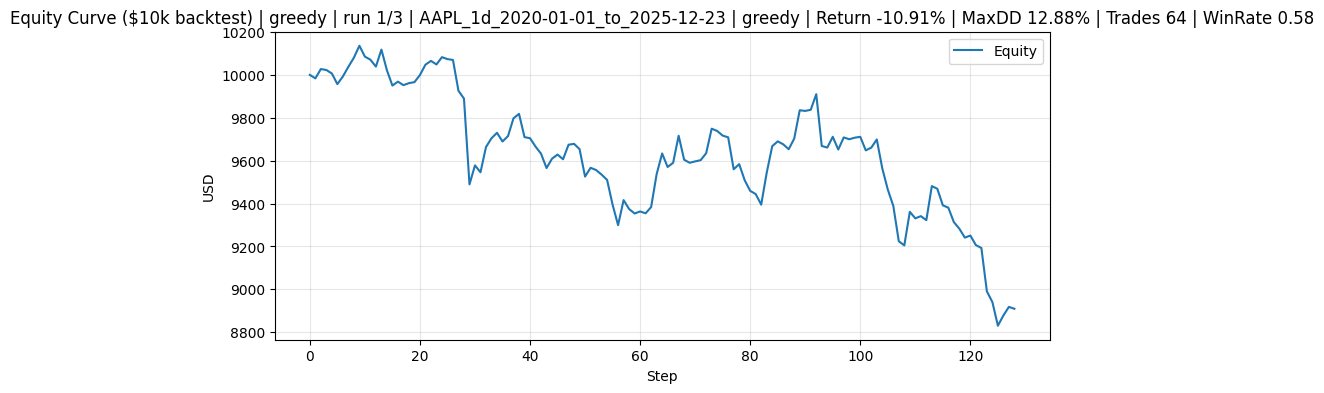


Last 10 trade events:
{'type': 'BUY', 'step': 119, 'price': 278.1600036621094, 'shares': 33.0, 'commission': 9.17928012084961, 'cash_after': 94.2405275421097}
{'type': 'SELL', 'step': 120, 'price': 277.75, 'shares': 33.0, 'commission': 9.165750000000001, 'cash_after': 9250.82477754211, 'pnl': -13.530120849609375, 'pnl_pct': -0.14739849608551941, 'hold_steps': 1}
{'type': 'BUY', 'step': 121, 'price': 279.1000061035156, 'shares': 33.0, 'commission': 9.210300201416016, 'cash_after': 31.31427592467844}
{'type': 'SELL', 'step': 122, 'price': 277.8999938964844, 'shares': 33.0, 'commission': 9.170699798583984, 'cash_after': 9192.843374710079, 'pnl': -39.60040283203125, 'pnl_pct': -0.42995778602246837, 'hold_steps': 1}
{'type': 'BUY', 'step': 123, 'price': 280.1499938964844, 'shares': 32.0, 'commission': 8.9647998046875, 'cash_after': 219.07877021789136}
{'type': 'SELL', 'step': 124, 'price': 272.82000732421875, 'shares': 32.0, 'commission': 8.730240234375, 'cash_after': 8940.588764358516, 'p

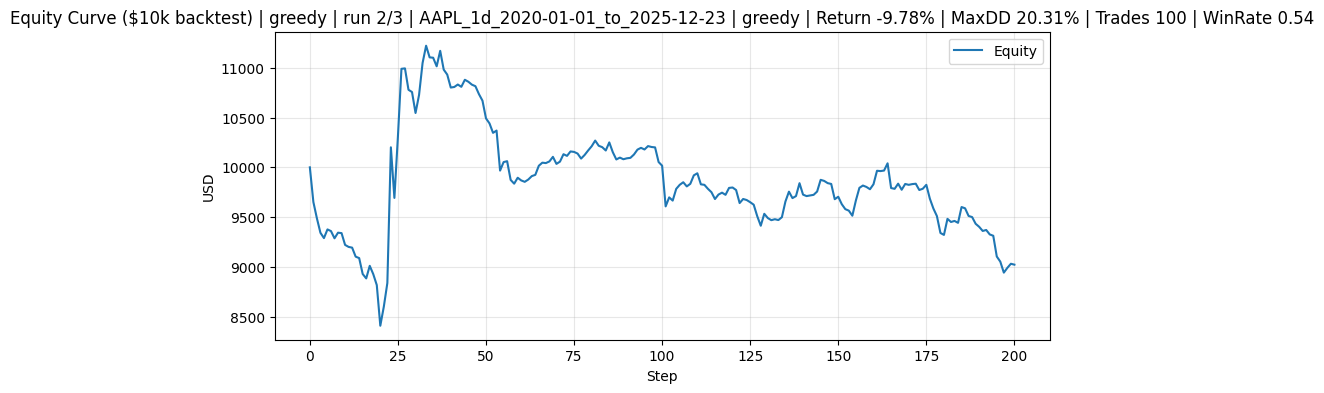


Last 10 trade events:
{'type': 'BUY', 'step': 191, 'price': 278.1600036621094, 'shares': 33.0, 'commission': 9.17928012084961, 'cash_after': 213.99120382689762}
{'type': 'SELL', 'step': 192, 'price': 277.75, 'shares': 33.0, 'commission': 9.165750000000001, 'cash_after': 9370.575453826898, 'pnl': -13.530120849609375, 'pnl_pct': -0.14739849608551941, 'hold_steps': 1}
{'type': 'BUY', 'step': 193, 'price': 279.1000061035156, 'shares': 33.0, 'commission': 9.210300201416016, 'cash_after': 151.06495220946636}
{'type': 'SELL', 'step': 194, 'price': 277.8999938964844, 'shares': 33.0, 'commission': 9.170699798583984, 'cash_after': 9312.594050994867, 'pnl': -39.60040283203125, 'pnl_pct': -0.42995778602246837, 'hold_steps': 1}
{'type': 'BUY', 'step': 195, 'price': 280.1499938964844, 'shares': 33.0, 'commission': 9.244949798583985, 'cash_after': 58.399302612298925}
{'type': 'SELL', 'step': 196, 'price': 272.82000732421875, 'shares': 33.0, 'commission': 9.003060241699218, 'cash_after': 9052.4564840

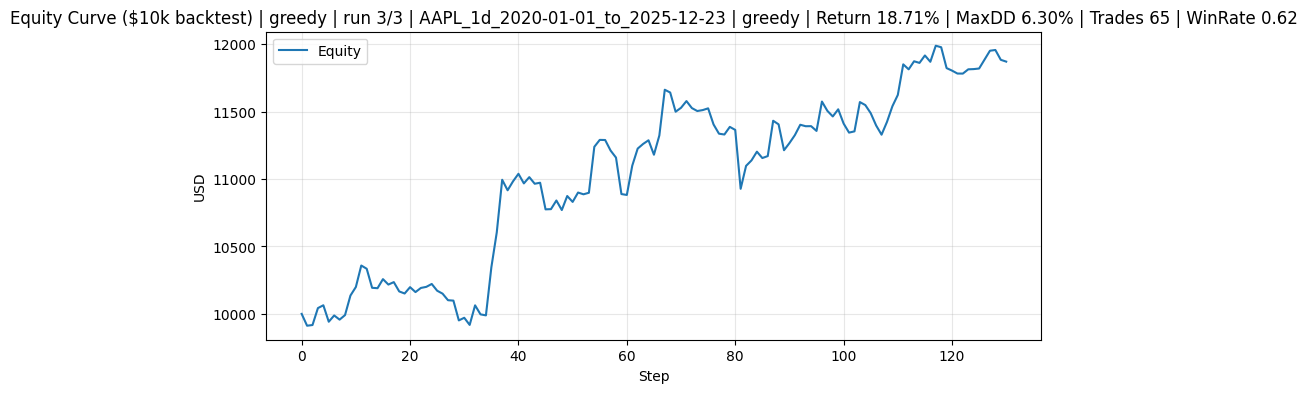


Last 10 trade events:
{'type': 'BUY', 'step': 121, 'price': 278.1300048828125, 'shares': 42.0, 'commission': 11.681460205078125, 'cash_after': 111.06429293823385}
{'type': 'SELL', 'step': 122, 'price': 278.1600036621094, 'shares': 42.0, 'commission': 11.682720153808594, 'cash_after': 11782.101726593019, 'pnl': 1.25994873046875, 'pnl_pct': 0.01078588385654928, 'hold_steps': 1}
{'type': 'BUY', 'step': 123, 'price': 277.75, 'shares': 42.0, 'commission': 11.6655, 'cash_after': 104.93622659301946}
{'type': 'SELL', 'step': 124, 'price': 279.1000061035156, 'shares': 42.0, 'commission': 11.722200256347657, 'cash_after': 11815.414282684327, 'pnl': 56.70025634765625, 'pnl_pct': 0.48605080234585957, 'hold_steps': 1}
{'type': 'BUY', 'step': 125, 'price': 277.8999938964844, 'shares': 42.0, 'commission': 11.671799743652343, 'cash_after': 131.94273928833172}
{'type': 'SELL', 'step': 126, 'price': 280.1499938964844, 'shares': 42.0, 'commission': 11.766299743652343, 'cash_after': 11886.476183197023, '

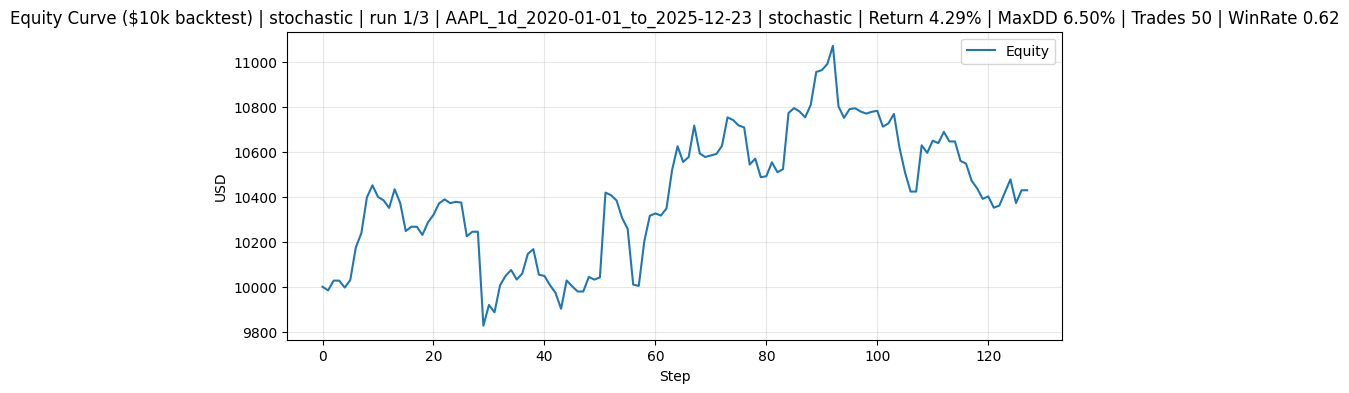


Last 10 trade events:
{'type': 'BUY', 'step': 115, 'price': 286.20001220703125, 'shares': 37.0, 'commission': 10.589400451660156, 'cash_after': 45.877943023686385}
{'type': 'SELL', 'step': 116, 'price': 284.1000061035156, 'shares': 37.0, 'commission': 10.511700225830078, 'cash_after': 10547.066468627934, 'pnl': -77.70022583007812, 'pnl_pct': -0.7337547218539332, 'hold_steps': 1}
{'type': 'BUY', 'step': 117, 'price': 280.5400085449219, 'shares': 37.0, 'commission': 10.37998031616211, 'cash_after': 156.70617214966296}
{'type': 'SELL', 'step': 118, 'price': 278.1300048828125, 'shares': 37.0, 'commission': 10.290810180664062, 'cash_after': 10437.225542633061, 'pnl': -89.17013549804688, 'pnl_pct': -0.8590588111155169, 'hold_steps': 1}
{'type': 'BUY', 'step': 119, 'price': 278.1600036621094, 'shares': 37.0, 'commission': 10.291920135498048, 'cash_after': 135.01348699951632}
{'type': 'SELL', 'step': 120, 'price': 277.75, 'shares': 37.0, 'commission': 10.27675, 'cash_after': 10401.48673699951

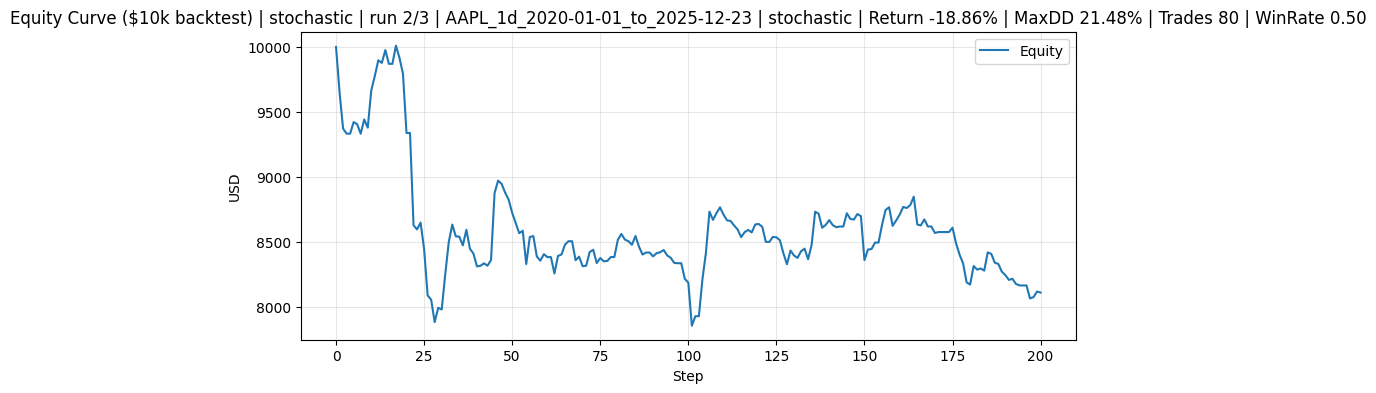


Last 10 trade events:
{'type': 'BUY', 'step': 187, 'price': 286.20001220703125, 'shares': 29.0, 'commission': 8.299800354003906, 'cash_after': 102.92121955871517}
{'type': 'SELL', 'step': 188, 'price': 284.1000061035156, 'shares': 29.0, 'commission': 8.238900177001954, 'cash_after': 8333.582496383666, 'pnl': -60.900177001953125, 'pnl_pct': -0.7337547218539332, 'hold_steps': 1}
{'type': 'BUY', 'step': 189, 'price': 280.5400085449219, 'shares': 29.0, 'commission': 8.135660247802734, 'cash_after': 189.78658833312875}
{'type': 'SELL', 'step': 190, 'price': 278.1300048828125, 'shares': 29.0, 'commission': 8.065770141601563, 'cash_after': 8247.49095979309, 'pnl': -69.89010620117188, 'pnl_pct': -0.8590588111155169, 'hold_steps': 1}
{'type': 'BUY', 'step': 191, 'price': 278.1600036621094, 'shares': 29.0, 'commission': 8.066640106201172, 'cash_after': 172.78421348571646}
{'type': 'SELL', 'step': 192, 'price': 277.75, 'shares': 29.0, 'commission': 8.05475, 'cash_after': 8219.479463485717, 'pnl'

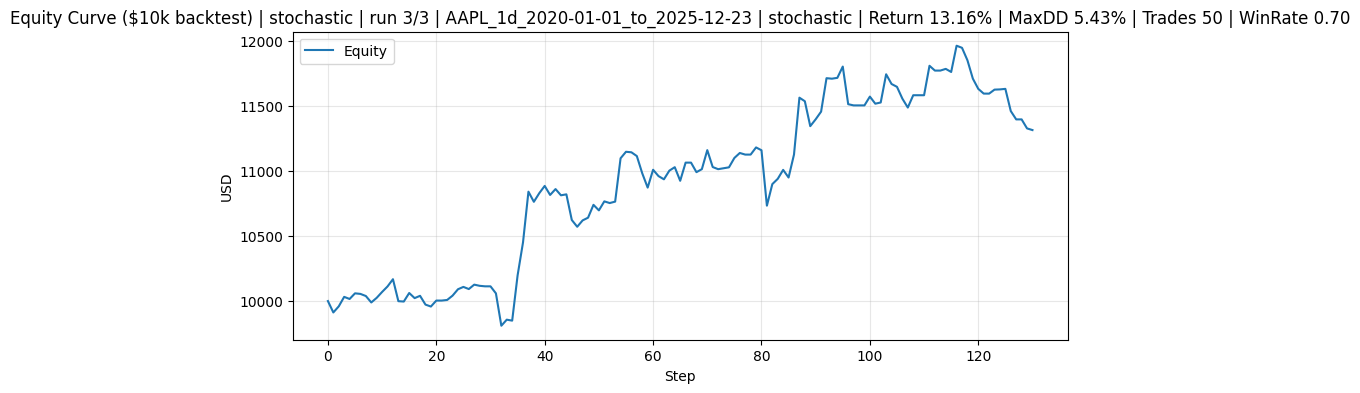


Last 10 trade events:
{'type': 'BUY', 'step': 116, 'price': 278.010009765625, 'shares': 42.0, 'commission': 11.67642041015625, 'cash_after': 75.65692120360472}
{'type': 'SELL', 'step': 117, 'price': 283.0, 'shares': 42.0, 'commission': 11.886000000000001, 'cash_after': 11949.770921203604, 'pnl': 209.57958984375, 'pnl_pct': 1.794895888310564, 'hold_steps': 1}
{'type': 'BUY', 'step': 118, 'price': 286.20001220703125, 'shares': 41.0, 'commission': 11.734200500488281, 'cash_after': 203.8362202148346}
{'type': 'SELL', 'step': 122, 'price': 278.1600036621094, 'shares': 41.0, 'commission': 11.404560150146485, 'cash_after': 11596.991810211173, 'pnl': -329.6403503417969, 'pnl_pct': -2.8092271844858963, 'hold_steps': 4}
{'type': 'BUY', 'step': 123, 'price': 277.75, 'shares': 41.0, 'commission': 11.38775, 'cash_after': 197.85406021117342}
{'type': 'SELL', 'step': 124, 'price': 279.1000061035156, 'shares': 41.0, 'commission': 11.443100250244141, 'cash_after': 11629.51121020507, 'pnl': 55.35025024

In [10]:
# Cell 10 — logically consistent $10k backtest + equity curve
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

# Assumes your action mapping is:
# 0 = SKIP/HOLD, 1 = BUY, 2 = CLOSE
A_SKIP, A_BUY, A_CLOSE = 0, 1, 2

def _get_price_series_and_meta(base_env):
    st = base_env._state
    inst = getattr(base_env, "_instrument", None)
    opens = st._prices.open
    closes = st._prices.close
    return opens, closes, inst, st

@torch.no_grad()
def select_action(model, obs, device, greedy=True, valid_mask=None):
    """
    Returns (action:int, probs:np.ndarray, logits:torch.Tensor).
    If valid_mask is provided (shape [3] bool), invalid actions are masked out.
    """
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, _ = model(obs_t)  # [1, n_actions]
    logits = logits.clone()

    if valid_mask is not None:
        valid_mask_t = torch.as_tensor(valid_mask, device=device).unsqueeze(0)  # [1, n_actions]
        # Set invalid logits to very negative so they are never chosen/sampled
        logits[~valid_mask_t] = -1e9

    dist = Categorical(logits=logits)
    if greedy:
        action = int(torch.argmax(logits, dim=1).item())
    else:
        action = int(dist.sample().item())

    probs = dist.probs.squeeze(0).detach().cpu().numpy()
    return action, probs, logits

def backtest_10k_equity_curve_v2(
    env,
    model,
    device,
    initial_cash=10_000.0,
    greedy=True,
    seed=None,
    max_steps=None,
    force_liquidate=True,
):
    """
    Logically consistent backtest:
      - Choose action from obs(t)
      - Execute trades at OPEN(t+1)
      - Mark-to-market equity at CLOSE(t)
      - Optional forced liquidation at final CLOSE
      - Action masking to avoid invalid BUY/CLOSE
    """
    model.eval()
    device = torch.device(device) if not isinstance(device, torch.device) else device
    base_env = env.unwrapped if hasattr(env, "unwrapped") else env

    obs, info = env.reset(seed=seed)
    opens, closes, inst, st = _get_price_series_and_meta(base_env)

    fee = float(getattr(st, "commission_perc", 0.0))  # e.g., 0.001 = 0.1%

    cash = float(initial_cash)
    shares = 0.0
    entry_price = None
    entry_step = None

    equity_curve = []
    price_curve = []
    pos_curve = []
    trades = []

    terminated = truncated = False
    steps = 0

    # --- Counters ---
    chosen_counts = {A_SKIP: 0, A_BUY: 0, A_CLOSE: 0}
    exec_counts   = {"BUY": 0, "SELL": 0, "LIQUIDATE": 0}

    # Helper: valid action mask based on position
    def valid_actions_mask(shares):
        holding = shares > 0
        # If holding: SKIP + CLOSE are valid, BUY invalid
        # If flat:    SKIP + BUY valid, CLOSE invalid
        return np.array([
            True,          # SKIP always valid
            (not holding), # BUY valid only when flat
            holding        # CLOSE valid only when holding
        ], dtype=bool)

    while True:
        # Mark-to-market at CLOSE(t)
        cur_close = float(st._cur_close())
        equity = cash + shares * cur_close

        equity_curve.append(equity)
        price_curve.append(cur_close)
        pos_curve.append(1 if shares > 0 else 0)

        if max_steps is not None and steps >= max_steps:
            break
        if terminated or truncated:
            break

        # Mask invalid actions so stats reflect real decisions
        mask = valid_actions_mask(shares)
        action, probs, _ = select_action(model, obs, device, greedy=greedy, valid_mask=mask)
        chosen_counts[action] += 1

        # Execution price: OPEN(t+1) (same assumption as your env)
        next_idx = int(st._offset + 1)
        exec_open = float(opens[next_idx]) if (0 <= next_idx < len(opens)) else None

        # Step env forward (updates st._offset internally)
        obs, reward, terminated, truncated, info = env.step(action)
        steps += 1

        if exec_open is None:
            # no execution possible (end of data)
            continue

        # --- Portfolio update at OPEN(t+1) ---
        if action == A_BUY and shares == 0:
            # All-in integer shares
            max_shares = np.floor(cash / (exec_open * (1.0 + fee)))
            if max_shares >= 1:
                max_shares = float(max_shares)
                commission = max_shares * exec_open * fee
                cost = max_shares * exec_open + commission
                cash -= cost
                shares = max_shares
                entry_price = exec_open
                entry_step = steps
                exec_counts["BUY"] += 1
                trades.append({
                    "type": "BUY",
                    "step": steps,
                    "price": exec_open,
                    "shares": shares,
                    "commission": float(commission),
                    "cash_after": float(cash),
                })

        elif action == A_CLOSE and shares > 0:
            commission = shares * exec_open * fee
            proceeds = shares * exec_open - commission
            cash += proceeds

            pnl = shares * (exec_open - float(entry_price))
            pnl_pct = ((exec_open - float(entry_price)) / float(entry_price)) * 100.0 if entry_price else 0.0

            exec_counts["SELL"] += 1
            trades.append({
                "type": "SELL",
                "step": steps,
                "price": exec_open,
                "shares": float(shares),
                "commission": float(commission),
                "cash_after": float(cash),
                "pnl": float(pnl),
                "pnl_pct": float(pnl_pct),
                "hold_steps": int(steps - entry_step) if entry_step is not None else None,
            })

            shares = 0.0
            entry_price = None
            entry_step = None

    # --- Optional forced liquidation at final CLOSE (common for backtests) ---
    if force_liquidate and shares > 0:
        last_close = float(st._cur_close())
        commission = shares * last_close * fee
        proceeds = shares * last_close - commission
        cash += proceeds

        pnl = shares * (last_close - float(entry_price))
        pnl_pct = ((last_close - float(entry_price)) / float(entry_price)) * 100.0 if entry_price else 0.0

        exec_counts["LIQUIDATE"] += 1
        trades.append({
            "type": "LIQUIDATE",
            "step": steps,
            "price": float(last_close),
            "shares": float(shares),
            "commission": float(commission),
            "cash_after": float(cash),
            "pnl": float(pnl),
            "pnl_pct": float(pnl_pct),
            "hold_steps": int(steps - entry_step) if entry_step is not None else None,
        })

        shares = 0.0
        entry_price = None
        entry_step = None

        # record final equity after liquidation
        equity_curve.append(float(cash))
        price_curve.append(float(last_close))
        pos_curve.append(0)

    equity_curve = np.asarray(equity_curve, dtype=np.float64)

    # --- Metrics ---
    final_equity = float(equity_curve[-1])
    total_return = (final_equity / float(initial_cash)) - 1.0

    peak = equity_curve[0]
    max_dd = 0.0
    for x in equity_curve:
        peak = max(peak, x)
        max_dd = max(max_dd, (peak - x) / max(peak, 1e-9))

    sells = [t for t in trades if t["type"] in ("SELL", "LIQUIDATE")]
    n_sells = len(sells)
    win_sells = sum(1 for t in sells if t.get("pnl", 0.0) > 0.0)
    win_rate = (win_sells / n_sells) if n_sells else 0.0

    avg_hold = float(np.mean([t["hold_steps"] for t in sells if t.get("hold_steps") is not None])) if n_sells else 0.0
    avg_pnl_usd = float(np.mean([t["pnl"] for t in sells])) if n_sells else 0.0
    avg_pnl_pct = float(np.mean([t["pnl_pct"] for t in sells])) if n_sells else 0.0

    total_chosen = max(1, sum(chosen_counts.values()))
    metrics = {
        "instrument": inst,
        "steps": int(len(equity_curve)),
        "initial_cash": float(initial_cash),
        "final_equity": float(final_equity),
        "total_return_pct": float(total_return * 100.0),
        "max_drawdown_pct": float(max_dd * 100.0),

        # executed trades
        "num_round_trips": int(n_sells),
        "win_rate": float(win_rate),
        "avg_hold_steps": float(avg_hold),
        "avg_trade_pnl_usd": float(avg_pnl_usd),
        "avg_trade_pnl_pct": float(avg_pnl_pct),

        # chosen action fractions (after masking -> meaningful)
        "chosen_frac_skip": float(chosen_counts[A_SKIP] / total_chosen),
        "chosen_frac_buy": float(chosen_counts[A_BUY] / total_chosen),
        "chosen_frac_close": float(chosen_counts[A_CLOSE] / total_chosen),

        # executed action counts
        "exec_buys": int(exec_counts["BUY"]),
        "exec_sells": int(exec_counts["SELL"]),
        "exec_liquidations": int(exec_counts["LIQUIDATE"]),

        "sizing": "all_in_int_shares",
        "commission_perc": float(fee),
        "force_liquidate": bool(force_liquidate),
        "policy_eval": "greedy" if greedy else "stochastic",
    }

    return {
        "equity_curve": equity_curve,
        "price_curve": np.asarray(price_curve, dtype=np.float64),
        "pos_curve": np.asarray(pos_curve, dtype=np.int64),
        "trades": trades,
        "metrics": metrics,
    }

def plot_equity(result, title="Equity Curve ($10k backtest)"):
    eq = result["equity_curve"]
    m = result["metrics"]
    plt.figure(figsize=(10, 4))
    plt.plot(eq, label="Equity")
    plt.title(
        f"{title} | {m.get('instrument')} | {m['policy_eval']} | "
        f"Return {m['total_return_pct']:.2f}% | MaxDD {m['max_drawdown_pct']:.2f}% | "
        f"Trades {m['num_round_trips']} | WinRate {m['win_rate']:.2f}"
    )
    plt.xlabel("Step")
    plt.ylabel("USD")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# --- load best model ---
best_path = os.path.join("saves", f"ppo_{config['run_name']}_best.pt")
if not os.path.exists(best_path):
    print(f"Best model checkpoint not found: {best_path}")
else:
    state = torch.load(best_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    print(f"Loaded best model from: {best_path}")

    # Run both greedy and stochastic validation backtests (recommended)
    for mode in [("greedy", True), ("stochastic", False)]:
        name, is_greedy = mode
        print("\n" + "#" * 70)
        print(f"Backtests using {name.upper()} policy")
        print("#" * 70)

        for i, sd in enumerate([0, 1, 2], start=1):
            bt = backtest_10k_equity_curve_v2(
                env=env_val,
                model=model,
                device=device,
                initial_cash=10_000.0,
                greedy=is_greedy,
                seed=sd,
                force_liquidate=True,
            )

            print("\n" + "=" * 60)
            print(f"Backtest Metrics ($10k, {name}, run {i}/3):")
            print("=" * 60)
            for k, v in bt["metrics"].items():
                print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
            print("=" * 60)

            plot_equity(bt, title=f"Equity Curve ($10k backtest) | {name} | run {i}/3")

            print("\nLast 10 trade events:")
            for t in bt["trades"][-10:]:
                print(t)